<h4> Zadanie1: CIFAR10 to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 x 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

https://www.cs.toronto.edu/~kriz/cifar.html

<h4> Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować loss w trakcie trenowania, testowania oraz accuracy na zbiorze testowym (opcjonalnie również na treningowym). Na koniec accuracy powinno osiągnąć wynik powyżej 70% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

- Zwiększenie treningowego batch size może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, batch_size ma wpływ na proces uczenia.
    
- Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu tych odpowiednich puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)

https://medmnist.com/ <- zobacz też na inne zbiory, mogą sie przydać do projektu

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
import numpy as np
from torch.utils.data import random_split
torch.manual_seed(42) 

In [2]:
#data preparation
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=False) #change to true to download (only once)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

#divide data: training/validation/testing set
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [3]:
#check data parametres
print(f"CIFAR10 classes: {len(dataset.classes)}")
print(f'Dataset lenght: {len(dataset)}')
print(f'Shape: {train_ds[0][0].shape}')

CIFAR10 classes: 10
Dataset lenght: 50000
Shape: torch.Size([3, 32, 32])


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #use GPU
num_classes=10

def train(model, num_epochs = 5, learning_rate = 0.001, batch_size=100, scheduler_factor=0.6, scheduler_patience=200):
    '''Train the model and plot graphs:
    1. Loss vs epochs
    2. Training, Val accuracy vs epoch
    '''

    #dataLoader
    train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True) #true to avoid learning patterns by data order
    val_loader = torch.utils.data.DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

    #loss function & optimalisator
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # scheduler ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)
    # mode='min'/'max'-> for decreasing/increasing loss
    # factor=0.1 -> decrease LR 10x
    # patience=5 -> number of allowed epochs with no improvement 

    #metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    #number of steps
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0 #correct predictions in train
        total_train = 0 #all predictions in train
        running_loss = 0 #loss list

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            #forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            #fackward & optimalisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            scheduler.step(loss) #update scheduler based on loss

            _, predicted = torch.max(outputs.data, 1) #prediced - class with higest logit (most propable)
            total_train += labels.size(0) #.size(0) -> size of dim 0 -> num of elements
            correct_train += (predicted == labels).sum().item()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item() :.4f}, LR: {scheduler.get_last_lr()[0] :.5f}')

        #Update mettics
        train_losses.append(running_loss / total_step) #average loss per batch
        train_accuracies.append(100 * correct_train / total_train)

        #Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad(): #no derivatives
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)  #prediced = class with higest logit (most propable)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracies.append(100 * correct_val / total_val)

    #testing
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accurtacies:\nTest: {100 * correct / total:.2f}% | Val: {val_accuracies[-1]}% | Train: {train_accuracies[-1]}%')

    #Save model
    torch.save(model.state_dict(), 'model.ckpt')

    #Plot graphs
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    #Loss grpah
    axs[0].plot(range(1, num_epochs+1), train_losses, marker='o', color='blue')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    
    #Accuracy graph
    axs[1].plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Acc', color='green')
    axs[1].plot(range(1, num_epochs+1), val_accuracies, marker='o', label='Val Acc', color='orange')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

Model 1: basic model + scheduler

In [5]:
# two-layer CNN (convolutional neural network)

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(16),     # Batch normalization: normalizes feature maps to stabilize and speed up training
            nn.ReLU(),              # ReLU activation: introduces non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling: reduces dimensions by taking the max in each 2x2 window
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),  # Second convolutional layer: increases feature depth (32)
            nn.BatchNorm2d(32),                                     # Normalization after convolution
            nn.ReLU(),                                             
            nn.MaxPool2d(kernel_size=2, stride=2))                 
        self.fc = nn.Linear(8*8*32, num_classes)  # Fully connected layer: maps flattened features to output classes
        
    def forward(self, x):
        out = self.layer1(x)                  
        out = self.layer2(out)                
        out = out.reshape(out.size(0), -1)    #flatten the output to (batch_size, features)
        out = self.fc(out)                    #pass through the fc layer for classification
        return out

Epoch [1/5], Step [100/350], Loss: 1.3860, LR: 0.00100
Epoch [1/5], Step [200/350], Loss: 1.3425, LR: 0.00100
Epoch [1/5], Step [300/350], Loss: 1.4903, LR: 0.00100
Epoch [2/5], Step [100/350], Loss: 1.0123, LR: 0.00100
Epoch [2/5], Step [200/350], Loss: 1.0605, LR: 0.00020
Epoch [2/5], Step [300/350], Loss: 0.9328, LR: 0.00004
Epoch [3/5], Step [100/350], Loss: 0.9191, LR: 0.00004
Epoch [3/5], Step [200/350], Loss: 0.7867, LR: 0.00001
Epoch [3/5], Step [300/350], Loss: 0.9165, LR: 0.00000
Epoch [4/5], Step [100/350], Loss: 0.9901, LR: 0.00000
Epoch [4/5], Step [200/350], Loss: 0.9529, LR: 0.00000
Epoch [4/5], Step [300/350], Loss: 1.0598, LR: 0.00000
Epoch [5/5], Step [100/350], Loss: 0.9533, LR: 0.00000
Epoch [5/5], Step [200/350], Loss: 0.9346, LR: 0.00000
Epoch [5/5], Step [300/350], Loss: 0.8568, LR: 0.00000
Accurtacies
 Test: 64.08% | Val: 64.90666666666667 | Train: 67.13714285714286


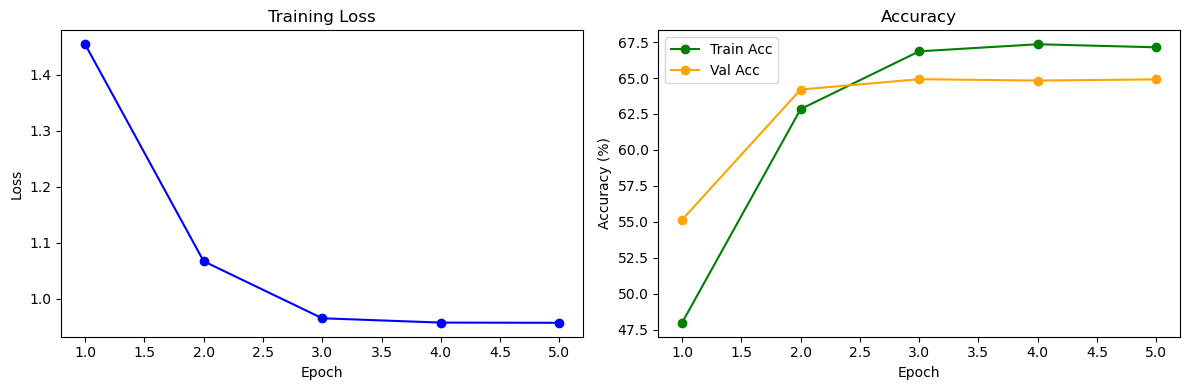

In [8]:
model = ConvNet(num_classes).to(device)
train(model, learning_rate=0.001, scheduler_factor=0.2, scheduler_patience=100)

Model 2:

    +dropout 
    +weight_decay 
    +extended fc

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #use GPU
num_classes=10


def train(model, num_epochs = 5, learning_rate = 0.001, batch_size=100, scheduler_factor=0.6, scheduler_patience=200, weight_decay=1e-5):

    #dataLoader
    train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)#true to avoid learning patterns by data order
    val_loader = torch.utils.data.DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

    #loss function n optimalisator
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # scheduler ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)
    # mode='min'/'max'-> for decreasing/increasing loss
    # factor=0.1 -> decrease LR 10x
    # patience=5 -> number of allowed epochs with no improvement 

    #metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    #number of steps
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            #Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward n optimalisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            scheduler.step(loss)

            _, predicted = torch.max(outputs.data, 1) #prediced is the class with higest logit (most propable)
            total_train += labels.size(0) #.size(0) -> size of dim 0 -> num of elements
            correct_train += (predicted == labels).sum().item()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item() :.4f}, LR: {scheduler.get_last_lr()[0] :.5f}')

        #Update mettics
        train_losses.append(running_loss / total_step)
        train_accuracies.append(100 * correct_train / total_train)

        #Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracies.append(100 * correct_val / total_val)

    #Testing
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accurtacies:\nTest: {100 * correct / total:.2f}% | Val: {val_accuracies[-1]}% | Train: {train_accuracies[-1]}%')

    #save model
    torch.save(model.state_dict(), 'model.ckpt')

    #plot grapgs
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    #loss graph
    axs[0].plot(range(1, num_epochs+1), train_losses, marker='o', color='blue')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    
    #accuracy graph
    axs[1].plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Acc', color='green')
    axs[1].plot(range(1, num_epochs+1), val_accuracies, marker='o', label='Val Acc', color='orange')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [47]:
#two-layer CNN (version 2)
dropout_prob=0.2
class ConvNet2(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),  #conv layer: 3 input channels → 16 output channels
            nn.BatchNorm2d(16),     
            nn.ReLU(),                                              
            nn.MaxPool2d(kernel_size=2, stride=2),  #downsampling by 2
            nn.Dropout(p=dropout_prob/3))#smaller dropout in conv layers (simple patterns, less susceptible to overfitting)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=dropout_prob/3)) 
        self.fc_layers = nn.Sequential( #extend the fc (fully connected) layer
            nn.Linear(8*8*32, 128),    #add hidden layer for better learning
            nn.ReLU(),
            nn.Dropout(p=dropout_prob), #higher dropout in fc (more abstract features, more prone to overfitting)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc_layers(out)
        return out

Epoch [1/5], Step [100/350], Loss: 1.6167, LR: 0.00100
Epoch [1/5], Step [200/350], Loss: 1.3815, LR: 0.00100
Epoch [1/5], Step [300/350], Loss: 1.1594, LR: 0.00100
Epoch [2/5], Step [100/350], Loss: 1.1701, LR: 0.00100
Epoch [2/5], Step [200/350], Loss: 1.2530, LR: 0.00100
Epoch [2/5], Step [300/350], Loss: 1.2688, LR: 0.00100
Epoch [3/5], Step [100/350], Loss: 0.9868, LR: 0.00020
Epoch [3/5], Step [200/350], Loss: 0.9252, LR: 0.00020
Epoch [3/5], Step [300/350], Loss: 1.1344, LR: 0.00020
Epoch [4/5], Step [100/350], Loss: 0.9694, LR: 0.00020
Epoch [4/5], Step [200/350], Loss: 1.0425, LR: 0.00020
Epoch [4/5], Step [300/350], Loss: 1.0169, LR: 0.00004
Epoch [5/5], Step [100/350], Loss: 1.0544, LR: 0.00004
Epoch [5/5], Step [200/350], Loss: 0.9880, LR: 0.00001
Epoch [5/5], Step [300/350], Loss: 0.9405, LR: 0.00000
Accurtacies
 Test: 67.27% | Val: 68.64 | Train: 66.61428571428571


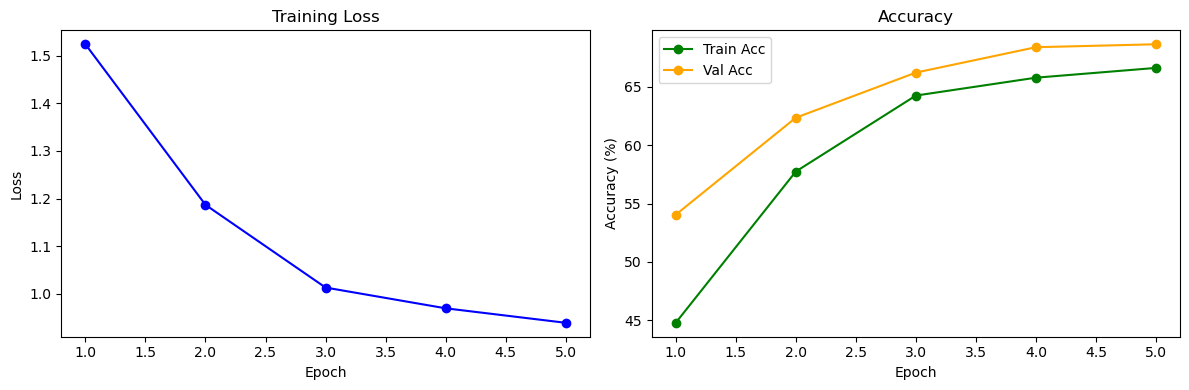

In [13]:
model = ConvNet2(num_classes).to(device)
train(model, learning_rate=0.001, batch_size=100, scheduler_factor=0.2, scheduler_patience=150, weight_decay=1e-5)

Training accuracy jest niższa, najprawdopodobniej dlatego, że zastosowaliśmy dropout w każdej warstwie i weight decay. Oznacza to, ze model miał 'trudniejsze' warunki przy uczeniu niż przy walidacji/teście.

Model 3:

    + another layer

In [65]:
#CNN (version 3)
dropout_prob=0.2
class ConvNet3(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(16),     
            nn.ReLU(),                                              
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob/3)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=dropout_prob/3)
            ) 
        self.layer3 = nn.Sequential(              #new layer to detect more datailed features (kernel size 3, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob/3)
            )
        self.fc_layers = nn.Sequential( 
            nn.Linear(4*4*64, 128),   
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, num_classes)
            )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc_layers(out)
        return out

Epoch [1/5], Step [100/350], Loss: 1.5999, LR: 0.00100
Epoch [1/5], Step [200/350], Loss: 1.4577, LR: 0.00100
Epoch [1/5], Step [300/350], Loss: 1.3120, LR: 0.00100
Epoch [2/5], Step [100/350], Loss: 1.0453, LR: 0.00100
Epoch [2/5], Step [200/350], Loss: 1.2641, LR: 0.00100
Epoch [2/5], Step [300/350], Loss: 1.1462, LR: 0.00100
Epoch [3/5], Step [100/350], Loss: 1.0198, LR: 0.00100
Epoch [3/5], Step [200/350], Loss: 0.9463, LR: 0.00100
Epoch [3/5], Step [300/350], Loss: 1.0578, LR: 0.00100
Epoch [4/5], Step [100/350], Loss: 1.0565, LR: 0.00100
Epoch [4/5], Step [200/350], Loss: 0.7546, LR: 0.00100
Epoch [4/5], Step [300/350], Loss: 0.7139, LR: 0.00020
Epoch [5/5], Step [100/350], Loss: 0.8312, LR: 0.00020
Epoch [5/5], Step [200/350], Loss: 0.8386, LR: 0.00020
Epoch [5/5], Step [300/350], Loss: 0.9660, LR: 0.00004
Accurtacies:
Test: 70.48% | Val: 70.76 | Train: 70.56


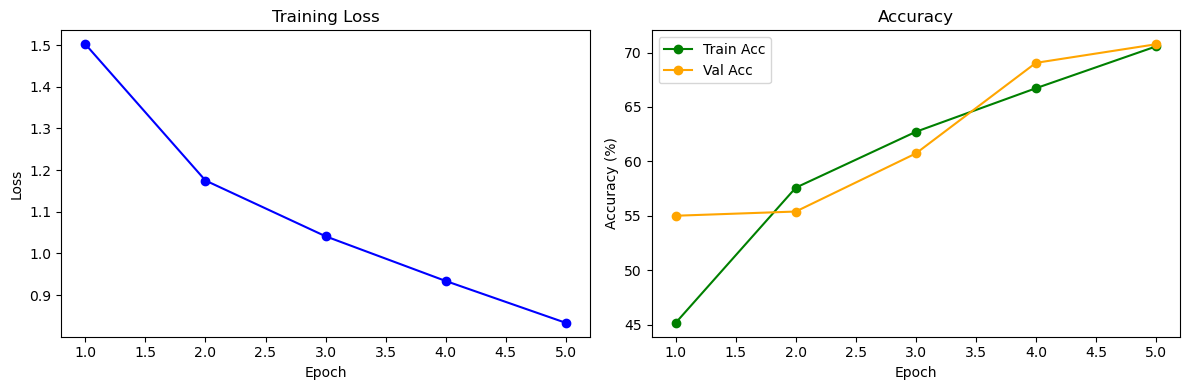

In [17]:
model = ConvNet3(num_classes).to(device)
train(model, learning_rate=0.001, batch_size=100, scheduler_factor=0.2, scheduler_patience=150, weight_decay=1e-5, num_epochs=5)

Final test on more epochs

Epoch [1/10], Step [100/350], Loss: 1.6655, LR: 0.00100
Epoch [1/10], Step [200/350], Loss: 1.6108, LR: 0.00100
Epoch [1/10], Step [300/350], Loss: 1.2996, LR: 0.00100
Epoch [2/10], Step [100/350], Loss: 1.3575, LR: 0.00100
Epoch [2/10], Step [200/350], Loss: 1.1604, LR: 0.00100
Epoch [2/10], Step [300/350], Loss: 1.1175, LR: 0.00020
Epoch [3/10], Step [100/350], Loss: 1.0513, LR: 0.00020
Epoch [3/10], Step [200/350], Loss: 0.8118, LR: 0.00020
Epoch [3/10], Step [300/350], Loss: 1.0580, LR: 0.00004
Epoch [4/10], Step [100/350], Loss: 1.0116, LR: 0.00001
Epoch [4/10], Step [200/350], Loss: 0.8058, LR: 0.00001
Epoch [4/10], Step [300/350], Loss: 0.9983, LR: 0.00000
Epoch [5/10], Step [100/350], Loss: 0.9982, LR: 0.00000
Epoch [5/10], Step [200/350], Loss: 0.8005, LR: 0.00000
Epoch [5/10], Step [300/350], Loss: 0.9860, LR: 0.00000
Epoch [6/10], Step [100/350], Loss: 0.8910, LR: 0.00000
Epoch [6/10], Step [200/350], Loss: 0.9097, LR: 0.00000
Epoch [6/10], Step [300/350], Loss: 1.0799, LR: 

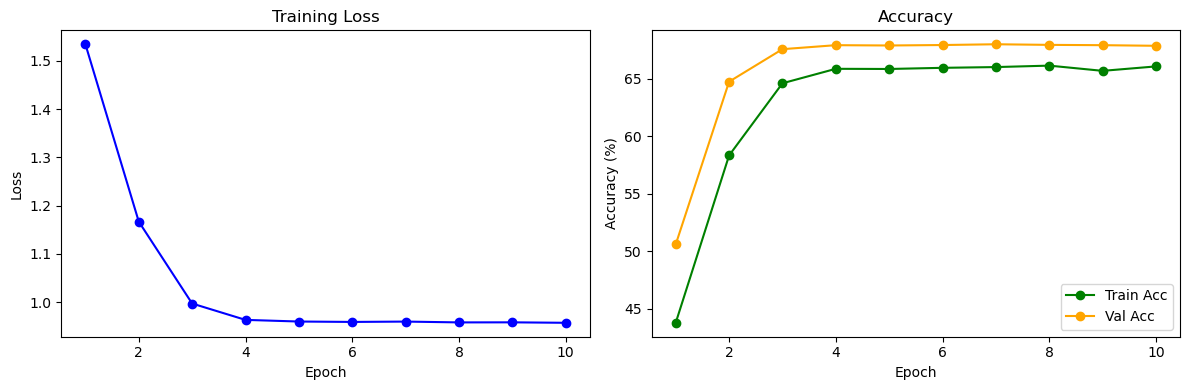

In [67]:
model = ConvNet3(num_classes).to(device)
train(model, learning_rate=0.001, batch_size=100, scheduler_factor=0.2, scheduler_patience=150, weight_decay=1e-5, num_epochs=10)

#na tym miałam 74.83% ale przez przypadek pusciłam cały kod i teraz nieważne co zrobie nie jestem w stanie zwiększyć accuracy:(((

<h4> Zadanie2: Rozważ tym razem dane PathMNIST. Podobnie jak wcześniej, zbuduj model klasyfikacji w oparciu o CNN. Dane należą do 1 z 9 kategorii (typy tkanek histopatologicznych). Oczekujemy przynajmniej 80 % na zbiorze testowym.

In [20]:
from torch.utils.data import DataLoader
from medmnist import PathMNIST

In [35]:
#normalizes the input images to help training stability and to speed up convergence
#Note: the exact values of mean and std here are arbitrary, they can be adjusted depending on the dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = PathMNIST(split='train', transform=transform, download=False)
test_dataset  = PathMNIST(split='test', transform=transform, download=False)
val_dataset = PathMNIST(split='val', transform=transform, download=False)

In [22]:
print(f'Img shape: {train_dataset[0][0].shape}')
print(f'Lab shape: {train_dataset[0][1].shape}')

Img shape: torch.Size([3, 28, 28])
Lab shape: (1,)


Model 1: 

    basic model 
    + scheduler

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #use GPU
num_classes=9

def train(model, num_epochs = 5, learning_rate = 0.001, batch_size=100, scheduler_factor=0.6, scheduler_patience=200):
    '''
    Train the model, chceck test accuracy and plot graphs:
    1. Loss vs epochs
    2. Training, Val accuracy vs epoch
    '''

    #dataLoader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) #true to avoid learning patterns by data order
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    

    #loss function n optimalisator
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # scheduler ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)
    # mode='min'/'max'-> for decreasing/increasing loss
    # factor=0.1 -> decrease LR 10x
    # patience=5 -> number of allowed epochs with no improvement 

    #metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    #number of steps
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0 #correct predictions in train
        total_train = 0 #all predictions in train
        running_loss = 0 #loss list

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.squeeze().long().to(device) #correct dims

            #Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward n optimalisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            scheduler.step(loss) #update scheduler based on loss

            _, predicted = torch.max(outputs.data, 1) #prediced is the class with higest logit (most propable)
            total_train += labels.size(0) #.size(0) -> size of dim 0 -> num of elements
            correct_train += (predicted == labels).sum().item()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item() :.4f}, LR: {scheduler.get_last_lr()[0] :.5f}')

        #Update mettics
        train_losses.append(running_loss / total_step) #average loss per batch
        train_accuracies.append(100 * correct_train / total_train)

        #Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad(): #no derivatives
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)  #prediced = class with higest logit (most propable)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracies.append(100 * correct_val / total_val)

    #testing
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accurtacies:\nTest: {100 * correct / total:.2f}% | Val: {val_accuracies[-1]}% | Train: {train_accuracies[-1]}%')

    #save model
    torch.save(model.state_dict(), 'model.ckpt')

    #plot grapgs
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    #loss graph
    axs[0].plot(range(1, num_epochs+1), train_losses, marker='o', color='blue')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    
    #accuracy graph
    axs[1].plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Acc', color='green')
    axs[1].plot(range(1, num_epochs+1), val_accuracies, marker='o', label='Val Acc', color='orange')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [37]:
#two-layer CNN (convolutional neural network)

class ConvNet1_1(nn.Module):
    def __init__(self, num_classes=9):
        super(ConvNet1_1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(16),     # Batch normalization: normalizes feature maps to stabilize and speed up training
            nn.ReLU(),              # ReLU activation: introduces non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling: reduces dimensions by taking the max in each 2x2 window
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),  # Second convolutional layer: increases feature depth (32)
            nn.BatchNorm2d(32),                                     # Normalization after convolution
            nn.ReLU(),                                             
            nn.MaxPool2d(kernel_size=2, stride=2))                 
        self.fc = nn.Linear(7*7*32, num_classes)  # Fully connected layer: maps flattened features to output classes
        
    def forward(self, x):
        out = self.layer1(x)                  
        out = self.layer2(out)                
        out = out.reshape(out.size(0), -1)    #flatten the output to (batch_size, features)
        out = self.fc(out)                    #pass through the fc layer for classification
        return out

Epoch [1/5], Step [100/900], Loss: 0.8725, LR: 0.00100
Epoch [1/5], Step [200/900], Loss: 0.7373, LR: 0.00100
Epoch [1/5], Step [300/900], Loss: 0.7075, LR: 0.00100
Epoch [1/5], Step [400/900], Loss: 0.6272, LR: 0.00100
Epoch [1/5], Step [500/900], Loss: 0.4997, LR: 0.00100
Epoch [1/5], Step [600/900], Loss: 0.4997, LR: 0.00100
Epoch [1/5], Step [700/900], Loss: 0.6616, LR: 0.00060
Epoch [1/5], Step [800/900], Loss: 0.5383, LR: 0.00060
Epoch [1/5], Step [900/900], Loss: 0.4370, LR: 0.00060
Epoch [2/5], Step [100/900], Loss: 0.4318, LR: 0.00060
Epoch [2/5], Step [200/900], Loss: 0.3828, LR: 0.00060
Epoch [2/5], Step [300/900], Loss: 0.4268, LR: 0.00036
Epoch [2/5], Step [400/900], Loss: 0.4556, LR: 0.00036
Epoch [2/5], Step [500/900], Loss: 0.4151, LR: 0.00036
Epoch [2/5], Step [600/900], Loss: 0.3579, LR: 0.00022
Epoch [2/5], Step [700/900], Loss: 0.5690, LR: 0.00022
Epoch [2/5], Step [800/900], Loss: 0.3278, LR: 0.00013
Epoch [2/5], Step [900/900], Loss: 0.6659, LR: 0.00013
Epoch [3/5

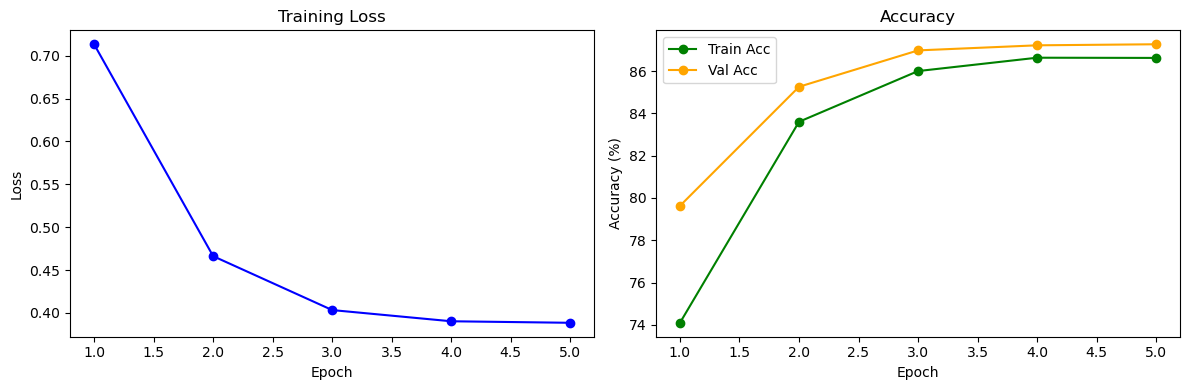

In [38]:
model = ConvNet1_1(num_classes).to(device)
train(model, learning_rate=0.001)

In [ ]:
#outcome on the basic model is satsfactiory but we'll test the best model on this data as well (CNN3)

Model 3: 

    +dropout 
    +weight_decay 
    +additional layer 
    +extended fc

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #use GPU
num_classes=9


def train(model, num_epochs = 5, learning_rate = 0.001, batch_size=100, scheduler_factor=0.6, scheduler_patience=200, weight_decay=1e-5):

    #dataLoader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)#true to avoid learning patterns by data order
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    #loss function n optimalisator
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # scheduler ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)
    # mode='min'/'max'-> for decreasing/increasing loss
    # factor=0.1 -> decrease LR 10x
    # patience=5 -> number of allowed epochs with no improvement 

    #metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    #number of steps
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            #Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward n optimalisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            scheduler.step(loss)

            _, predicted = torch.max(outputs.data, 1) #prediced is the class with higest logit (most propable)
            total_train += labels.size(0) #.size(0) -> size of dim 0 -> num of elements
            correct_train += (predicted == labels).sum().item()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item() :.4f}, LR: {scheduler.get_last_lr()[0] :.5f}')

        #Update mettics
        train_losses.append(running_loss / total_step)
        train_accuracies.append(100 * correct_train / total_train)

        #Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracies.append(100 * correct_val / total_val)

    #Testing
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accurtacies:\nTest: {100 * correct / total:.2f}% | Val: {val_accuracies[-1]} | Train: {train_accuracies[-1]}')

    #save model
    torch.save(model.state_dict(), 'model.ckpt')

    #plot grapgs
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    #loss graph
    axs[0].plot(range(1, num_epochs+1), train_losses, marker='o', color='blue')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    
    #accuracy graph
    axs[1].plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Acc', color='green')
    axs[1].plot(range(1, num_epochs+1), val_accuracies, marker='o', label='Val Acc', color='orange')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [42]:
#CNN (version 3)
dropout_prob=0.2
class ConvNet3(nn.Module):
    def __init__(self, num_classes=9):
        super(ConvNet3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(16),     
            nn.ReLU(),                                              
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob/3)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=dropout_prob/3)
            ) 
        self.layer3 = nn.Sequential( #new layer to learn details (kernel size 3, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob/3)
            )
        self.fc_layers = nn.Sequential( 
            nn.Linear(3*3*64, 128),   
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, num_classes)
            )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc_layers(out)
        return out

Epoch [1/5], Step [100/300], Loss: 0.6657, LR: 0.00100
Epoch [1/5], Step [200/300], Loss: 0.6712, LR: 0.00100
Epoch [1/5], Step [300/300], Loss: 0.5986, LR: 0.00100
Epoch [2/5], Step [100/300], Loss: 0.4746, LR: 0.00100
Epoch [2/5], Step [200/300], Loss: 0.5662, LR: 0.00100
Epoch [2/5], Step [300/300], Loss: 0.4621, LR: 0.00100
Epoch [3/5], Step [100/300], Loss: 0.4536, LR: 0.00100
Epoch [3/5], Step [200/300], Loss: 0.4556, LR: 0.00100
Epoch [3/5], Step [300/300], Loss: 0.3866, LR: 0.00100
Epoch [4/5], Step [100/300], Loss: 0.2929, LR: 0.00100
Epoch [4/5], Step [200/300], Loss: 0.3409, LR: 0.00100
Epoch [4/5], Step [300/300], Loss: 0.3205, LR: 0.00100
Epoch [5/5], Step [100/300], Loss: 0.3167, LR: 0.00100
Epoch [5/5], Step [200/300], Loss: 0.2713, LR: 0.00100
Epoch [5/5], Step [300/300], Loss: 0.1739, LR: 0.00020
Accurtacies:
Test: 79.23% | Val: 92.02319072371051 | Train: 89.94844215298458


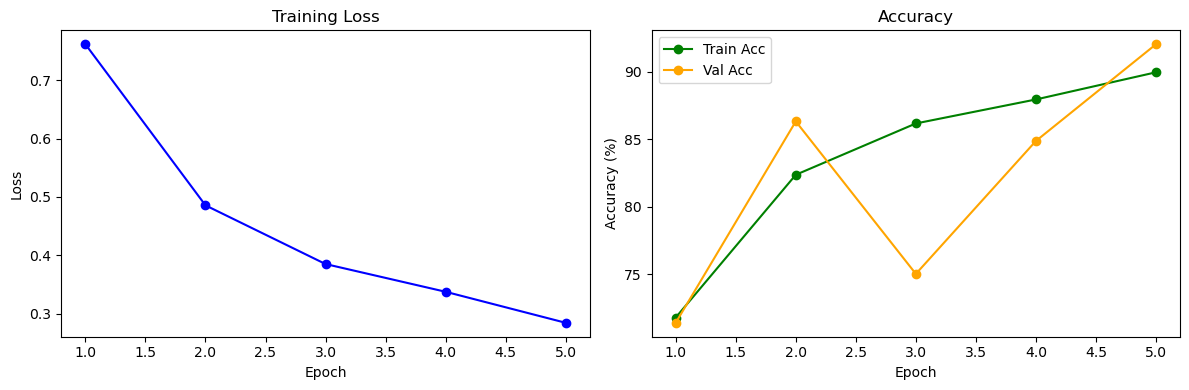

In [44]:
model = ConvNet3(num_classes).to(device)
train(model, learning_rate=0.001, batch_size=300, scheduler_factor=0.2, scheduler_patience=150, weight_decay=1e-5, num_epochs=5)

overtraing, solutions:
-increase weight decay
-increase dropout.prob
-decrease batch size